In this notebook, I will generate the SubPositive dataset from the AllPositive2 dataset, and perform and visualize PCA, tSNE and UMAP techniques.

First, defining the path:

In [1]:
import os
import sys
import gensim
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

ROOT = os.path.dirname(os.getcwd())
path_data = '/mnt/scratch/rebac002/data/AllPositive2'
sys.path.insert(0, ROOT)

Picking the correct file (AllPositive2 dataset):

In [2]:
import pickle
outfile = os.path.join(path_data,'ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups.pickle')
with open(outfile, 'rb') as filename:
    spectrums = pickle.load(filename)

In [38]:
print(type(spectrums))

<class 'list'>


Text(0, 0.5, 'number of spectra in respective bin')

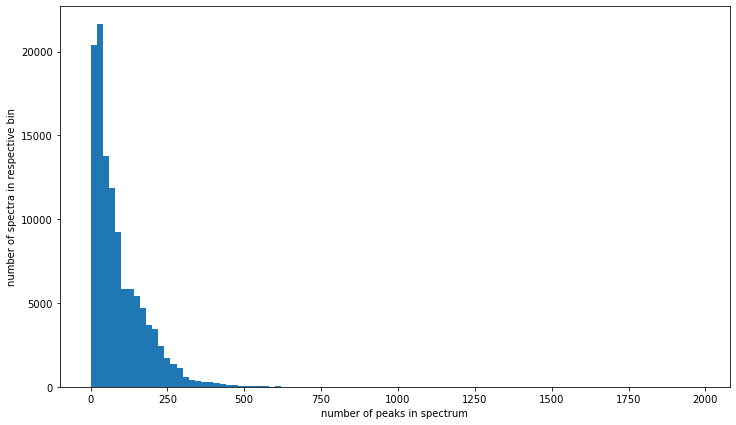

In [3]:
number_of_peaks = [len(spec.peaks) for spec in spectrums]

plt.figure(figsize=(12,7))
hist = plt.hist(number_of_peaks, np.arange(0,2000,20))
plt.xlabel("number of peaks in spectrum")
plt.ylabel("number of spectra in respective bin")

**Post-process data**

We here do different post-processing for either the "classical" scores (Cosine, modified Cosine) or Spe2Vec. The reason for this is mostly to make sure that we do full justice to the classical similarity measures.

**Post-processing for Spec2Vec**
Spec2Vec similarity scores rely on creating a document vector for each spectrum. For the underlying word2vec model we want the documents (=spectra) to be more homogeneous in their number of unique words. Assuming that larger compounds will on average break down into a higher number of meaningful fragment peaks we reduce the document size of each spectrum according to its parent mass.

-normalize peaks (maximum intensity to 1)
-remove peaks outside [0, 1000] m/z window
-remove spectra with < 10 peaks
-reduce number of peaks to maximum of 0.5 * parent mass
-remove peaks with intensities < 0.001 of maximum intensity (unless this brings number of peaks to less than 10)

In [4]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import add_losses


def post_process_s2v(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5)
    if s is None:
        return None
    s_remove_low_peaks = select_by_relative_intensity(s, intensity_from=0.001)
    if len(s_remove_low_peaks.peaks) >= 10:
        s = s_remove_low_peaks
        
    s = add_losses(s, loss_mz_from=5.0, loss_mz_to=200.0)
    return s

# apply post processing steps to the data
spectrums_s2v = [post_process_s2v(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums_s2v = [s for s in spectrums_s2v if s is not None]

print("{} remaining spectra.".format(len(spectrums_s2v)))

115388 remaining spectra.


In [43]:
print(len(spectrums_s2v))

115388


In [5]:
pickle.dump(spectrums_s2v, 
            open(os.path.join(path_data,'ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups.pickle'), "wb"))

In [6]:
outfile = os.path.join(path_data,'ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups.pickle')
with open(outfile, 'rb') as file:
    spectrums_s2v = pickle.load(file)

In [7]:
np.max(number_of_peaks)

982

Text(0, 0.5, 'number of spectra in respective bin')

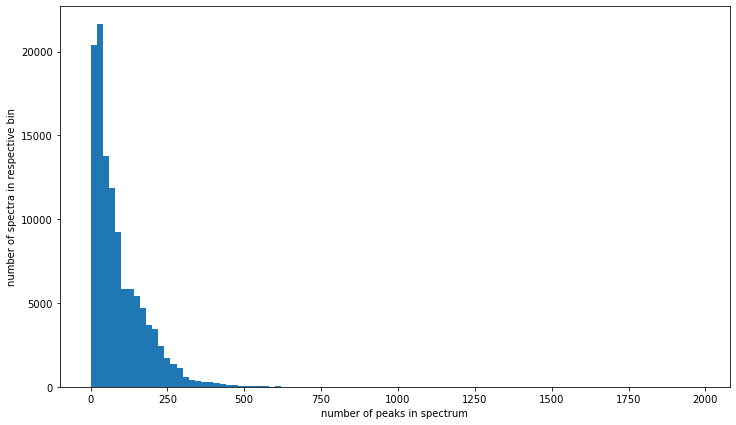

In [8]:
number_of_peaks = [len(spec.peaks) for spec in spectrums_s2v]

plt.figure(figsize=(12,7))
hist = plt.hist(number_of_peaks, np.arange(0,2000,20))
plt.xlabel("number of peaks in spectrum")
plt.ylabel("number of spectra in respective bin")

**Inspect annotations**

In [9]:
Inchikeys = []
for spec in spectrums_s2v:
    Inchikeys.append(spec.get("inchikey"))

inchikeys_pd = pd.Series([x for x in Inchikeys if x])
inchikeys_pd.str[:14].value_counts()[:20]

NEGQHKSYEYVFTD    432
SULIDBRAXVDKBU    426
SRIGHEHXEGELQJ    338
IQGPMZRCLCCXAG    308
IIZPXYDJLKNOIY    235
RWKUXQNLWDTSLO    235
FYVNIFOYDIIODX    235
BHWGKAVGUMMQIW    230
QIBZFHLFHCIUOT    225
ZAYXPDDGEIJGGW    212
QJWDAOSZZYVBJZ    211
KILNVBDSWZSGLL    209
RFVFQQWKPSOBED    203
IRYMXEVDAKMFIF    198
IESVDEZGAHUQJU    197
SNKAWJBJQDLSFF    196
LFUDDCMNKWEORN    195
JLPULHDHAOZNQI    182
XGGMHQYOVYWRLV    180
LSOWKZULVQWMLY    180
dtype: int64

Text(0, 0.5, 'Number of inchikeys with respective number of occurences')

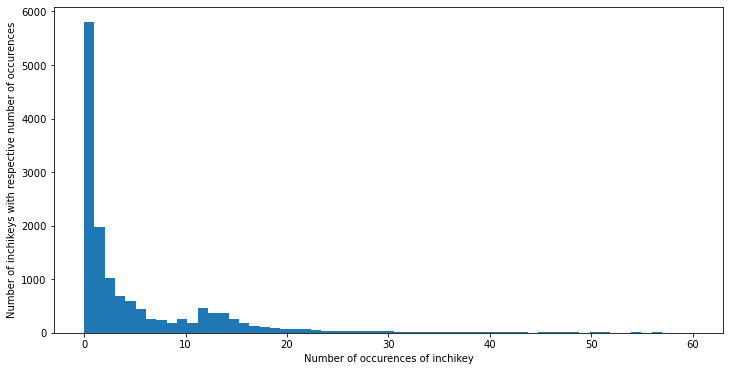

In [11]:
plt.figure(figsize=(12,6))
plt.hist(inchikeys_pd.str[:14].value_counts(), np.linspace(0, 60, 60))
plt.xlabel('Number of occurences of inchikey')
plt.ylabel('Number of inchikeys with respective number of occurences')

**Randomly select 1000 inchikeys that exist >=30 times in the dataset**

In [12]:
min_copies_in_data = 30 #min nr of spectra per inchikey

suitable_inchikeys = pd.DataFrame(inchikeys_pd.str[:14].value_counts()[inchikeys_pd.str[:14].value_counts().values >= min_copies_in_data])
suitable_inchikeys.reset_index(level=suitable_inchikeys.index.names, inplace=True)
suitable_inchikeys.columns = (['inchikey14', 'occurences'])

# Important: sort values to make it reproducible (same occurences have random order otherwise!)
suitable_inchikeys = suitable_inchikeys.sort_values(['occurences', 'inchikey14'], ascending=False)
suitable_inchikeys.head(15)

,inchikey14,occurences
0,NEGQHKSYEYVFTD,432
1,SULIDBRAXVDKBU,426
2,SRIGHEHXEGELQJ,338
3,IQGPMZRCLCCXAG,308
5,RWKUXQNLWDTSLO,235
4,IIZPXYDJLKNOIY,235
6,FYVNIFOYDIIODX,235
7,BHWGKAVGUMMQIW,230
8,QIBZFHLFHCIUOT,225
9,ZAYXPDDGEIJGGW,212


In [13]:
print(pd.DataFrame(inchikeys_pd.str[:14].value_counts()[inchikeys_pd.str[:14].value_counts().values >= min_copies_in_data]))

                  0
NEGQHKSYEYVFTD  432
SULIDBRAXVDKBU  426
SRIGHEHXEGELQJ  338
IQGPMZRCLCCXAG  308
IIZPXYDJLKNOIY  235
...             ...
SQVIAVUSQAWMKL   30
UFCLZKMFXSILNL   30
MQTOSJVFKKJCRP   30
DVGGLGXQSFURLP   30
METKIMKYRPQLGS   30

[404 rows x 1 columns]


In [14]:
print(inchikeys_pd.str[:14].value_counts()[inchikeys_pd.str[:14].value_counts().values])

RNWHJFUXZQBBLK     28
FMGSKLZLMKYGDP     29
QYIXCDOBOSTCEI     33
QANMHLXAZMSUEX     35
RFDAIACWWDREDC     42
                 ... 
SULIDBRAXVDKBU    426
SULIDBRAXVDKBU    426
SULIDBRAXVDKBU    426
SULIDBRAXVDKBU    426
SULIDBRAXVDKBU    426
Length: 14488, dtype: int64


In [15]:
print(f"Number of spectra with inchikeys that exist >= {min_copies_in_data} times:", suitable_inchikeys.shape[0])
#check how many spectra there are for inchikeys that exist 30 or more times

Number of spectra with inchikeys that exist >= 30 times: 404


Here, select the inchikeys:

In [16]:
num_spectra = 20 #how many do you want to randomly select?
np.random.seed(35) # to make it reproducible

selection = np.random.choice(suitable_inchikeys.shape[0], num_spectra, replace=False)
selected_inchikeys = suitable_inchikeys['inchikey14'].values[selection]
selected_inchikeys

array(['TTWJBBZEZQICBI', 'QJWDAOSZZYVBJZ', 'HPNSFSBZBAHARI',
       'MCWXGJITAZMZEV', 'CLEXYFLHGFJONT', 'QUQPHWDTPGMPEX',
       'LNEPOXFFQSENCJ', 'WQZGKKKJIJFFOK', 'MUMGGOZAMZWBJJ',
       'DNTGGZPQPQTDQF', 'OXASEZHJIONDOQ', 'NGFMICBWJRZIBI',
       'REFJWTPEDVJJIY', 'SVOUGFFDROZBJI', 'ODKSFYDXXFIFQN',
       'SOSLMHZOJATCCP', 'UATOAILWGVYRQS', 'XSDQTOBWRPYKKA',
       'JLPULHDHAOZNQI', 'RPTUKVYGSPDHGQ'], dtype=object)

In [17]:
print(len(selected_inchikeys)) #check how many inchikeys are selected

20


Now that we selcted the inchikeys, we need to trace back which spectra they represent and select those spectra:

In [18]:
selected_spectra = []
inchikeys_pd = pd.Series([x for x in Inchikeys]) #include all even empty ones to get the IDs right!
np.random.seed(35) # to make it reproducible
for inchikey in selected_inchikeys:
    matches = inchikeys_pd[inchikeys_pd.str[:14] == inchikey].index.values
    selected_spectra.extend(matches)

In [19]:
print(len(selected_spectra)) #check how many spectra are selected

1313


Import model pre-trained on AllPositive2 dataset (will need it for vector calculation):

In [20]:
filename_path = "ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups_spec2vec_embedding_iter_15.model"
filename_model = os.path.join(path_data, filename_path)

pretrained_model = gensim.models.Word2Vec.load(filename_model)

In [21]:
next(iter(pretrained_model.wv.vocab))

'peak@289.29'

In [22]:
from spec2vec import SpectrumDocument

spectrum_documents = [SpectrumDocument(s, n_decimals=2) for i, s in enumerate(spectrums_s2v) if i in selected_spectra]

from spec2vec import Spec2Vec
spec2vec_similarity = Spec2Vec(model=model,
                               intensity_weighting_power=0.5,
                               allowed_missing_percentage=5.0)

The function "calc_vector" calculates only a single vector from a single document. To make it calculate all our vectors from spectrum_documents, a for loop is used. I also used a numpy array instead of a regular list to improve performance. Each "single_vector" is a list of 300 (dimensions), and there are 1313 "single_vector"s in total.

In [23]:
from typing import Union
import numba
from gensim.models.basemodel import BaseTopicModel
from spec2vec.Document import Document
from spec2vec.vector_operations import calc_vector

list_of_vectors = []
for i in spectrum_documents:
    single_vector = calc_vector(pretrained_model, i)
    list_of_vectors.append(single_vector)
    
spec_vectors = np.stack(list_of_vectors)

In [24]:
len(spec_vectors)

1313

Before going on to visualization, indices for the spectra will be needed. Or in other words, a list with the same length as spec_vectors, where spec_inchikeys[0] will represent the inchikey of spec_vectors[0].

In order to do this, the same order of spectra needs to be preserved as was made in spectrum_documents. So we will generate a properly ordered list of selected spectra, and retreive the inchikeys for them.

In [25]:
spec_inchikeys = [] #new list for inchikeys matching spec_vectors

for i, s in enumerate(spectrums_s2v):
    if i in selected_spectra:
        spec_inchikeys.append(s.metadata.get("inchikey")[:14])

In [53]:
print(type(selected_spectra))

<class 'list'>


**PCA VISUALIZATION**

In [26]:
from pca import pca
import numpy as np

#load dataset
spec_dataset = pd.DataFrame(spec_vectors, index=spec_inchikeys,
                            columns = [str(i) for i in range(spec_vectors.shape[1])])

#reduce the data up to the number of components that explains 95% of the variance
#pca_model = pca(n_components=0.95)

#reduce data towards n PCs
pca_model = pca(n_components=3)

pca_results = pca_model.fit_transform(spec_dataset)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [300] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


In [55]:
print(type(pca_model))
print(type(pca_results))

<class 'pca.pca.pca'>
<class 'dict'>


Scatter plot:

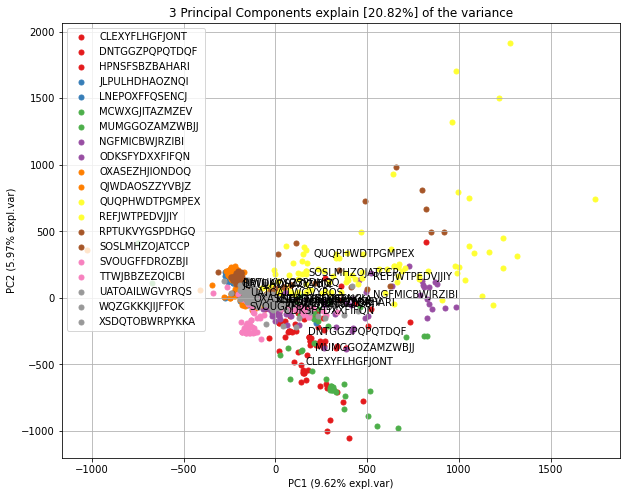

In [27]:
fig, ax = pca_model.scatter()

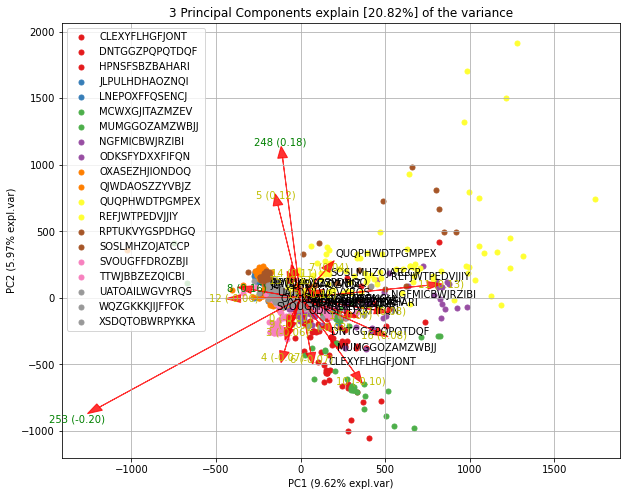

In [28]:
fig, ax = pca_model.biplot(n_feat=20)

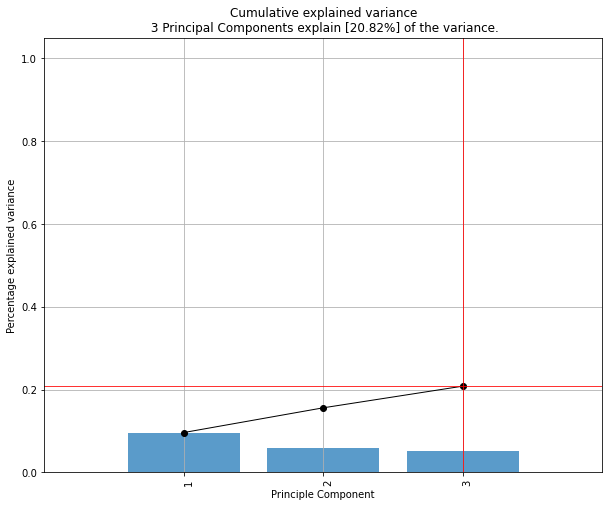

<Figure size 432x288 with 0 Axes>

In [29]:
fig, ax = pca_model.plot()

/mnt/scratch/rebac002/miniconda3/envs/BSc_Thesis/lib/python3.8/site-packages/pca/pca.py:821: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)


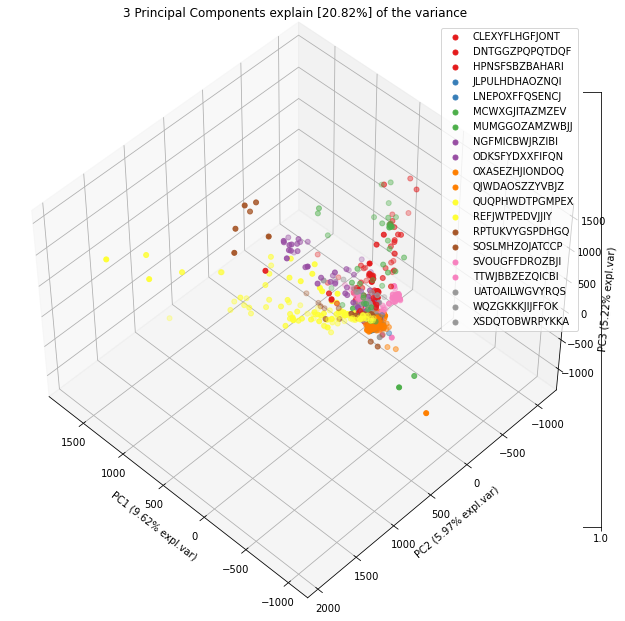

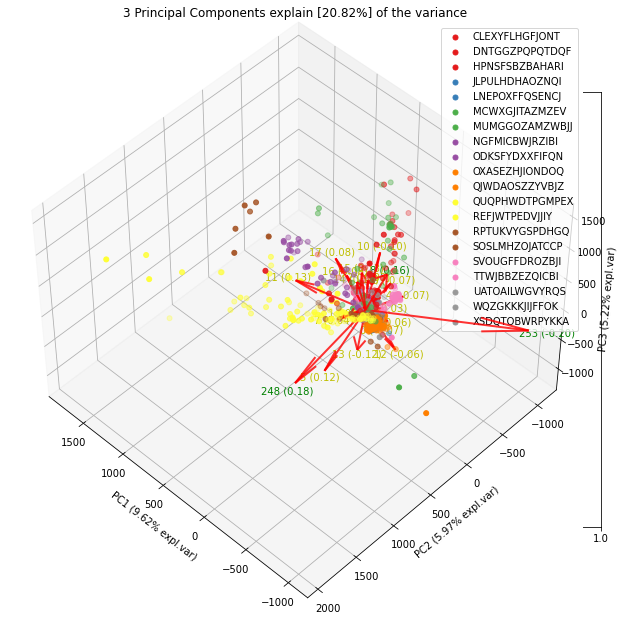

In [30]:
fig, ax = pca_model.scatter3d()
fig, ax = pca_model.biplot3d(n_feat=20)

Now, to perform t-SNE.

As mentioned in the user guide: "It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples."

In [31]:
from __future__ import print_function
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#dimensionality reduction with PCA, as recommended
pca = PCA(n_components=3)
pca_result = pca.fit_transform(spec_dataset)

#perform tSNE
tsne_model = TSNE(n_components=2, verbose=1)
tsne_results = tsne_model.fit_transform(spec_dataset)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1313 samples in 0.001s...
[t-SNE] Computed neighbors for 1313 samples in 0.127s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1313
[t-SNE] Computed conditional probabilities for sample 1313 / 1313
[t-SNE] Mean sigma: 127.065686
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.418739
[t-SNE] KL divergence after 1000 iterations: 0.924138


To plot t-SNE, I will use seaborn (sns):

In [32]:
#create array with colors
tSNE_colors = ['#E6194B', '#3CB44B', '#FFE119', '#4363D8', '#F58231',
                '#911EB4', '#46F0F0', '#F032E6', '#BCF60C', '#FABEBE',
                '#008080', '#E6BEFF', '#9A6324', '#FFFAC8', '#800000',
                '#AAFFC3', '#808000', '#FFD8B1', '#000075', '#808080',
                '#FFFFFF', '#000000']

#set custom color palette
tSNE_palette = sns.set_palette(sns.color_palette(tSNE_colors))

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

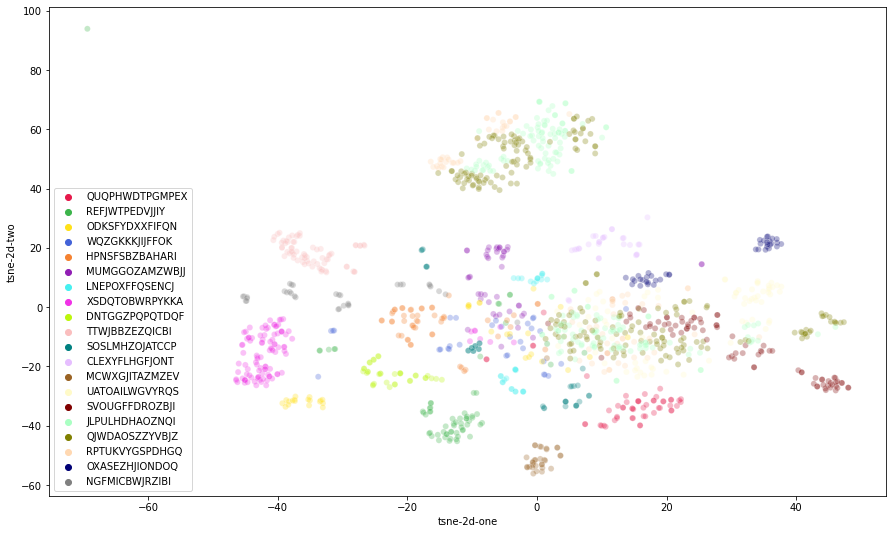

In [33]:
#define the x and y axes
spec_dataset['tsne-2d-one'] = tsne_results[:,0]
spec_dataset['tsne-2d-two'] = tsne_results[:,1]

#make the scatterplot using seaborn
plt.figure(figsize=(15,9)) #adjust plot size for easier interpretation
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue=spec_dataset.index,
                palette=tSNE_palette,
                data=spec_dataset, legend="full", alpha=0.3)

Finally, to perform UMAP:

In [34]:
import umap

umap_results = umap.UMAP().fit_transform(spec_dataset)

<AxesSubplot:xlabel='UMAP-one', ylabel='UMAP-two'>

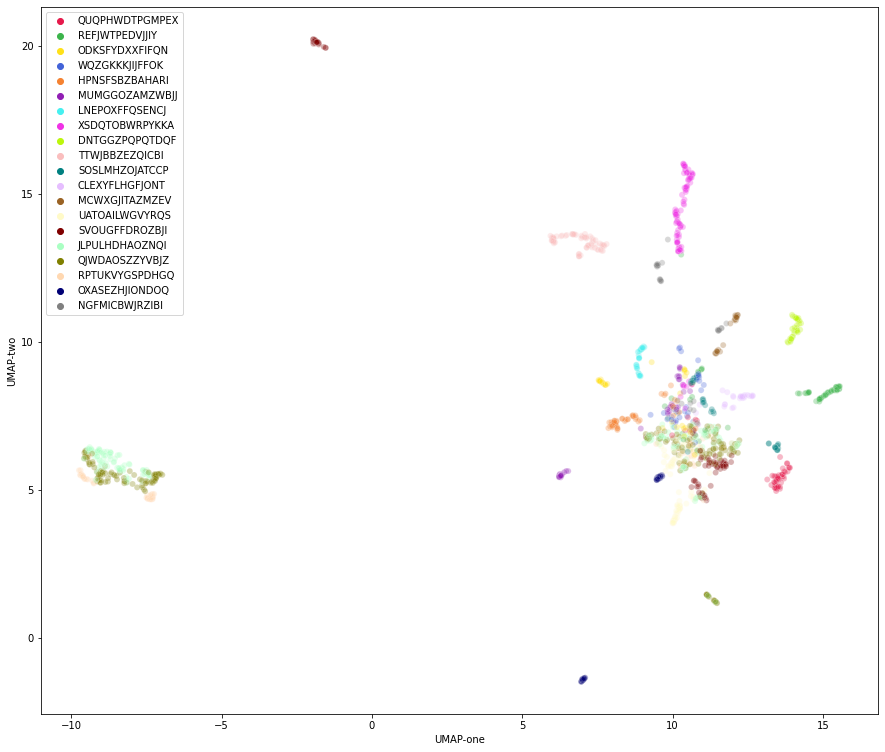

In [35]:
#define the x and y axes
spec_dataset['UMAP-one'] = umap_results[:,0]
spec_dataset['UMAP-two'] = umap_results[:,1]

#make the scatterplot using seaborn
plt.figure(figsize=(15,13)) #adjust plot size for easier interpretation
sns.scatterplot(x="UMAP-one", y="UMAP-two",
                hue=spec_dataset.index,
                palette=tSNE_palette,
                data=spec_dataset, legend="full", alpha=0.3)